<a href="https://colab.research.google.com/github/du-hr/covid-atals/blob/main/MiniProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID Atalas: Analyzing COVID-19 Search Trends and Hospitalization with ML


> MiniProject 1 of COMP 551 (Fall 2020) at McGill University


> Authors (G68): Haoran Du, Cong Zhu, Matthew Kourlas





In [50]:
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

## Task 1: Acquire, preprocess, and analyze the data.

### 1.1 Download the datasets. Load the datasets into Pandas dataframes or NumPy objects (i.e., arrays or matrices) in Python.

In [51]:

url_search = "https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv"
url_hospital = "https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv"

df_search = pd.read_csv(url_search, low_memory=False)
df_hospital = pd.read_csv(url_hospital, low_memory=False)

pd.set_option('display.max_columns', None)


###1.2 Clean the data. Remove regions and features that have too many missing or invalid data entries.

In [52]:
print("Length of search dataset before cleaning = " + str(len(df_search)))
df_search.dropna(thresh=8, inplace=True)
df_search.dropna(axis=1, how="all", inplace=True)
print("Length of search dataset after cleaning = " + str(len(df_search)))

print("\nLength of hospital dataset before cleaning = " + str(len(df_hospital)))

df_hospital = df_hospital[ (df_hospital["open_covid_region_code"] >= "US-A") & (df_hospital["open_covid_region_code"] <= "US-Z") ]
df_hospital.dropna(axis=1, how="all", inplace=True)
print("Length of hospital dataset after cleaning = " + str(len(df_hospital)))

Length of search dataset before cleaning = 640
Length of search dataset after cleaning = 599

Length of hospital dataset before cleaning = 102912
Length of hospital dataset after cleaning = 12821


###1.3 Merge the two datasets. Bring both the datasets at the weekly resolution and thereafter merge them into one array (Numpy or Pandas).

In [53]:



df_search["date"] = pd.to_datetime(df_search["date"])

df_hospital["date"] = pd.to_datetime(df_hospital["date"])

df_search = df_search.set_index(["date"])
df_search = df_search.shift(periods=6, freq="D")
df_hospital = df_hospital.set_index(["date"])


grouper = df_hospital.groupby([pd.Grouper(freq='1W'), 'open_covid_region_code'])
df_hospital = grouper['hospitalized_new', 'hospitalized_cumulative'].sum()

df_search = df_search.groupby(by=["date", "open_covid_region_code"]).sum()

df_hospital = df_hospital.drop(["2020-10-11", "2020-10-04"])
df_search = df_search.drop(["2020-01-12", "2020-01-19"])

df = pd.concat([df_hospital, df_search], axis=1, sort=False)

df.dropna(thresh=122, inplace=True)

# print(df)
# from google.colab import files

# df.to_csv('df.csv')
# files.download('df.csv')





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


## Task 2: Visualize and cluster the data

### 2.1 Visualize how the distribution of search frequency of each symptom aggregated across different regions changes over time.

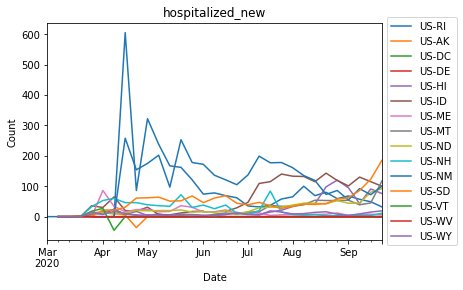

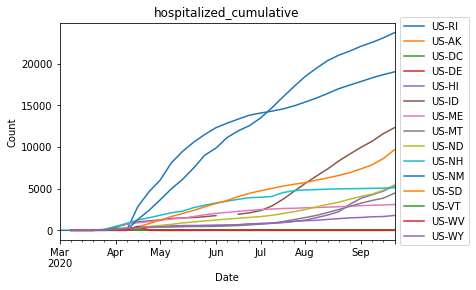

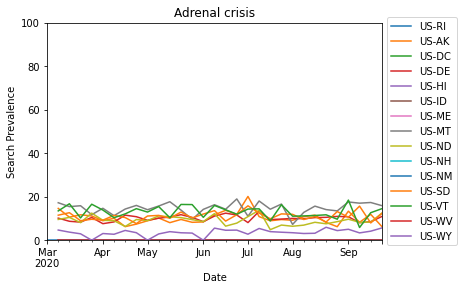

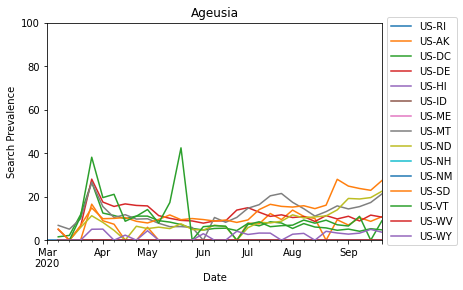

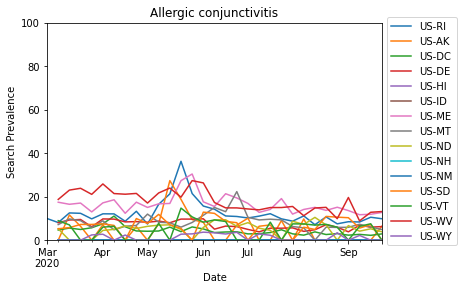

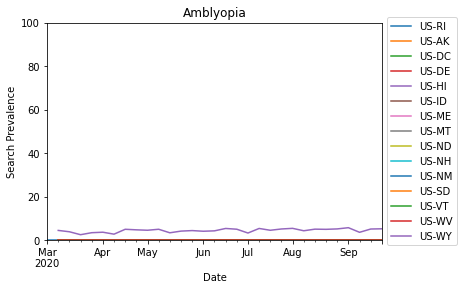

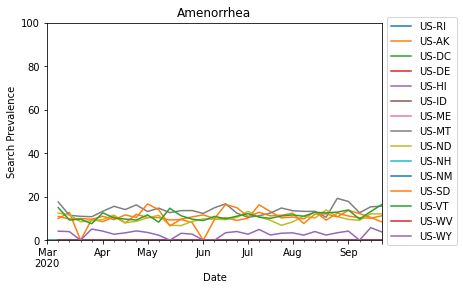

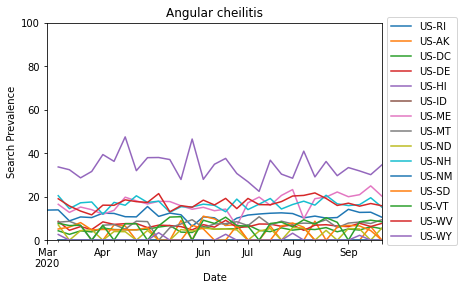

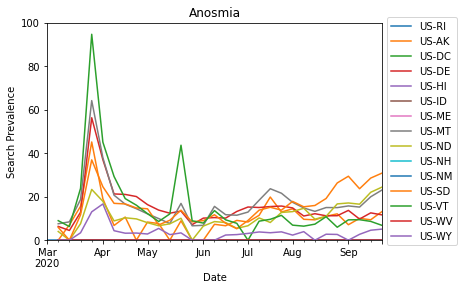

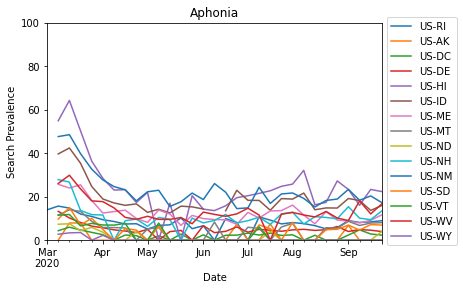

--- Full list of symptoms ---
symptom:Adrenal crisis
symptom:Ageusia
symptom:Allergic conjunctivitis
symptom:Amblyopia
symptom:Amenorrhea
symptom:Angular cheilitis
symptom:Anosmia
symptom:Aphonia


In [54]:
# Current visualization strategy: plot features over time (symptom/hospitalization stat) separately from
# each other, but aggregating all regions for each feature

# Choose set of symptoms to plot (ex. symptoms = ['symptom:Balance disorder', 'symptom:Rheum'])
# Graphing all symptoms for now, takes several minutes
symptoms = [symptom for symptom in df.columns.values if symptom.startswith('symptom')][:8]

unstacked = df.unstack(level=[1])

# Generate hospitalization plots (not required by project, just for our benefit)
for stat in {'hospitalized_new', 'hospitalized_cumulative'}:
    p = unstacked[stat].plot()
    p.set_title(stat)
    p.set_xlabel("Date")
    p.set_ylabel("Count")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Generate symptom plots
for symptom in symptoms:
    p = unstacked[symptom].plot()
    p.set_title(symptom[8:])  # remove 'symptom:' prefix
    p.set_xlabel("Date")
    p.set_ylabel("Search Prevalence")
    plt.ylim((0,100)) # search prevalence ranges from 0 to 100
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

# Print full list of symptoms    
print("--- Full list of symptoms ---")
for symptom in symptoms:
    print(symptom)

###2.2 Visualize the search trends dataset in a lower dimensional space.

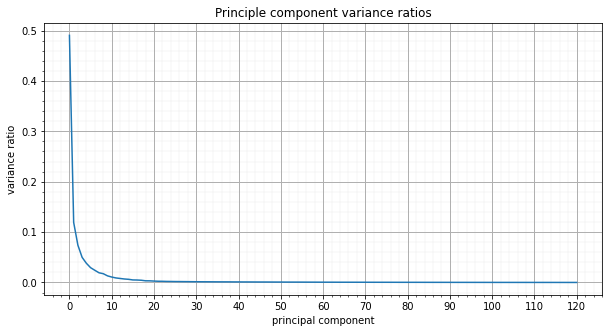

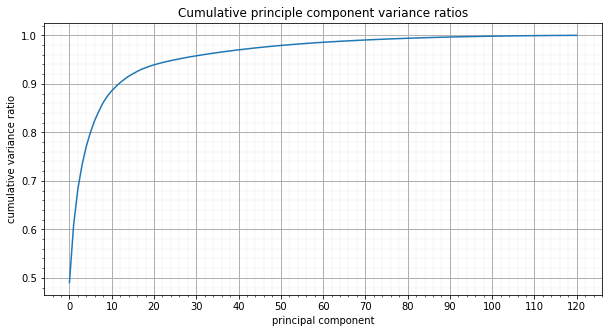

     principal component 1  principal component 2  hospitalized_new
0                -5.697338              -3.119986               0.0
1                14.212675               6.554208               0.0
2                -5.002889               0.032335               0.0
3                 1.098805              -4.856952               0.0
4                -7.517163               0.937703               0.0
..                     ...                    ...               ...
445              -5.682768              -2.891729              32.0
446              10.186469              -3.745095             185.0
447              15.263355               0.451908               0.0
448              -6.834679              -4.343307               0.0
449               0.190533               8.272682              19.0

[450 rows x 3 columns]


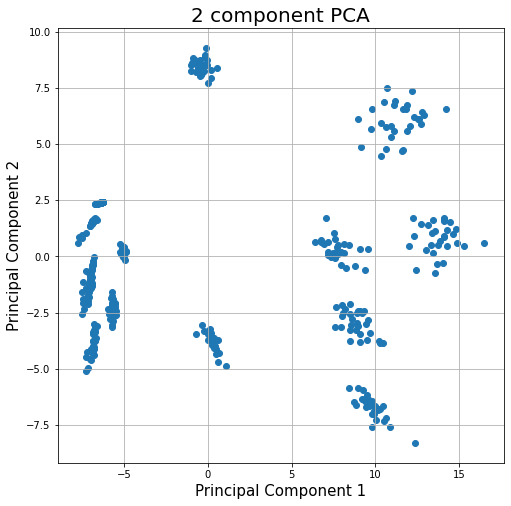

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_var_ratios(var_ratios, cumsum=False):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    if cumsum:
        ax.plot(np.cumsum(var_ratios))
        ax.set_title("Cumulative principle component variance ratios")
        ax.set_ylabel("cumulative variance ratio")
    else:
        ax.plot(var_ratios)
        ax.set_title("Principle component variance ratios")
        ax.set_ylabel("variance ratio")
    ax.set_xticks(np.arange(0, len(var_ratios)+1, 10))
    ax.set_xlabel("principal component")
    ax.minorticks_on()
    ax.grid(which='major', linewidth=1)
    ax.grid(which='minor', linewidth=0.1)
    plt.show()

features = [symptom for symptom in df.columns.values if symptom.startswith('symptom')]
# Separating out the features
x = df.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# Determine and variance ratios of PCs
pca = PCA()
pca.fit_transform(x)
var_ratios = pca.explained_variance_ratio_
plot_var_ratios(var_ratios)
plot_var_ratios(var_ratios, True)

# PCA Projection to 1 PC
# TODO choose PC
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# reduced dataframe
df_copy = df.reset_index()
df_reduced = pd.concat([principalDf, df_copy[['hospitalized_new']]], axis = 1)
print(df_reduced)

# Visualize 2D Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(df_reduced['principal component 1'], df_reduced['principal component 2'])
ax.grid()


###2.3 Explore using a clustering method (k-means) to evaluate possible groups in the search trends dataset. Do the clusters remain consistent for raw as well as PCA-reduced data?

For 1 clusters:
Raw cost: 2074362.9427333334
PCA cost: 33195.24519051165
Adjusted Rand Index: 1.0


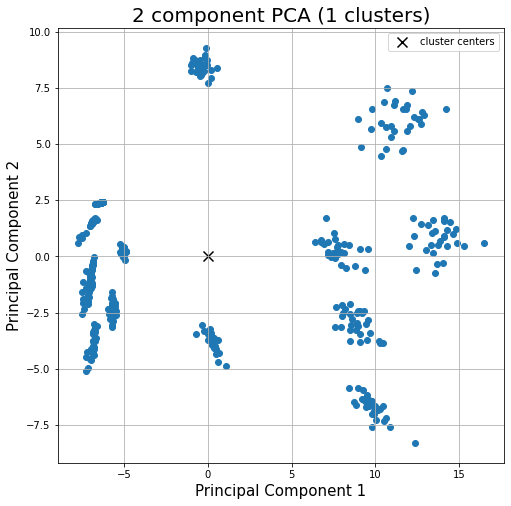

For 2 clusters:
Raw cost: 1285085.3646689998
PCA cost: 9278.535381659389
Adjusted Rand Index: 1.0


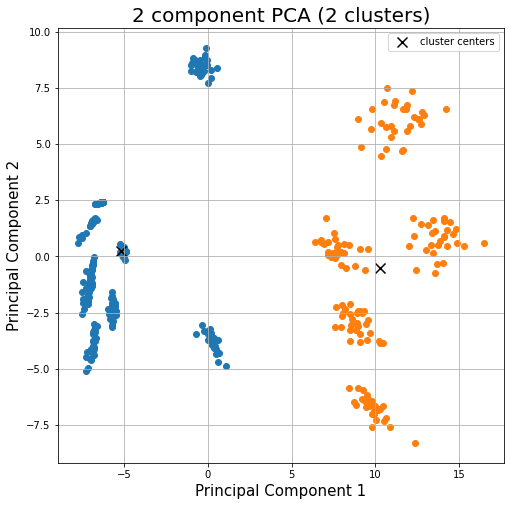

For 3 clusters:
Raw cost: 1086772.676532935
PCA cost: 6280.056084233187
Adjusted Rand Index: 0.5477516391775542


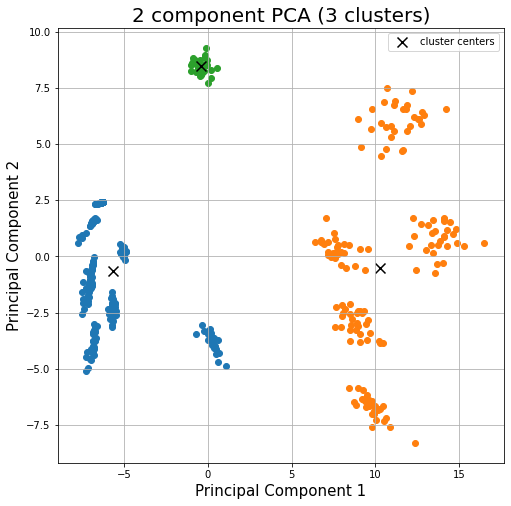

For 4 clusters:
Raw cost: 975320.1898341808
PCA cost: 4228.357012955545
Adjusted Rand Index: 0.3313570630551854


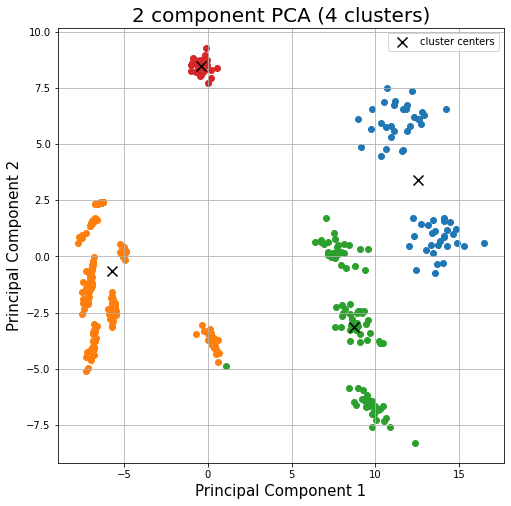

For 5 clusters:
Raw cost: 882135.4047531809
PCA cost: 2728.4142901627793
Adjusted Rand Index: 0.32254483296518854


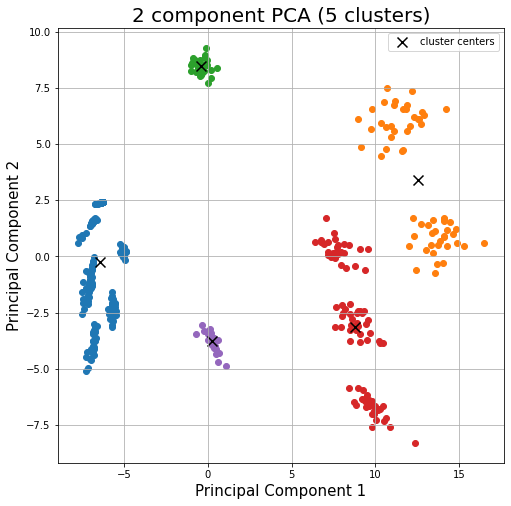

For 6 clusters:
Raw cost: 792649.0026866342
PCA cost: 1879.2791373809175
Adjusted Rand Index: 0.6443533222884779


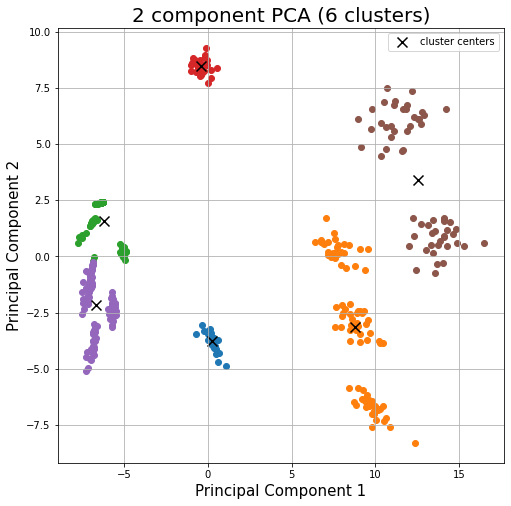

For 7 clusters:
Raw cost: 730037.1307330265
PCA cost: 1243.8986311677309
Adjusted Rand Index: 0.7636118799004221


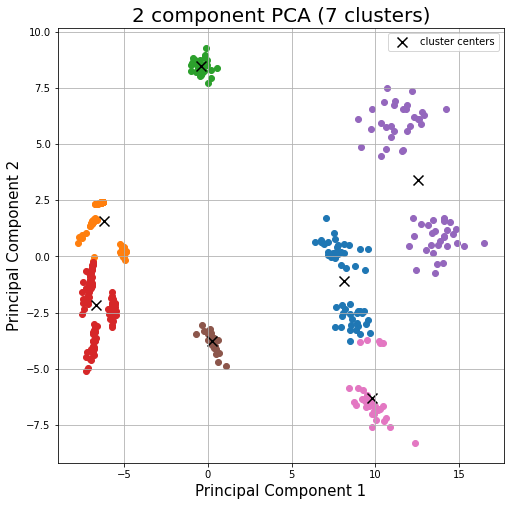

For 8 clusters:
Raw cost: 676564.21875776
PCA cost: 746.7657848804545
Adjusted Rand Index: 0.6232980190061003


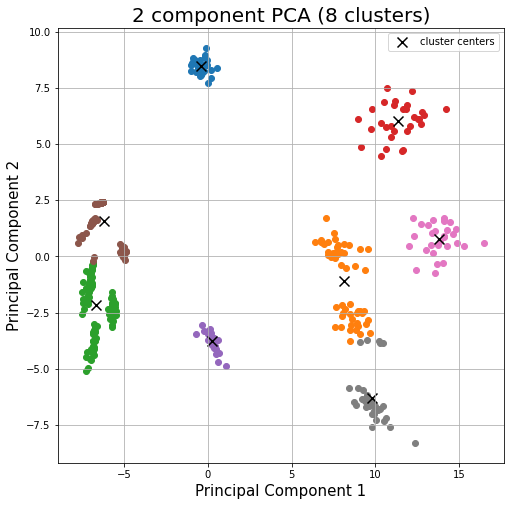

For 9 clusters:
Raw cost: 634195.7753264805
PCA cost: 576.6077144422854
Adjusted Rand Index: 0.6600188269640529


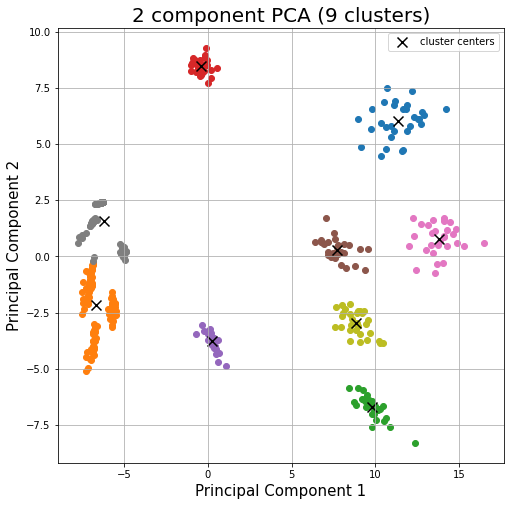

For 10 clusters:
Raw cost: 578393.5294015517
PCA cost: 420.4516454421165
Adjusted Rand Index: 0.6080220560907135


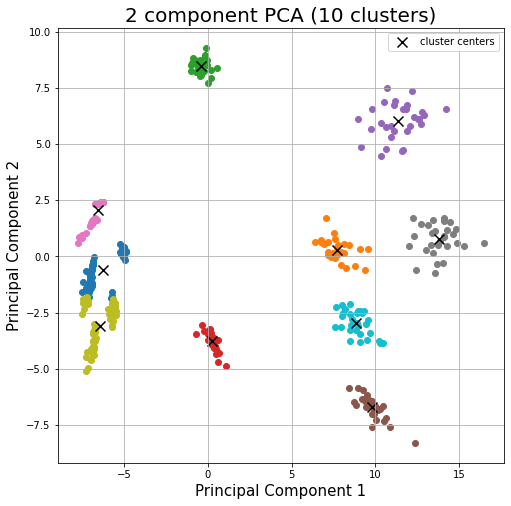

For 11 clusters:
Raw cost: 536123.7818414047
PCA cost: 310.9353036016064
Adjusted Rand Index: 0.6907946209026273


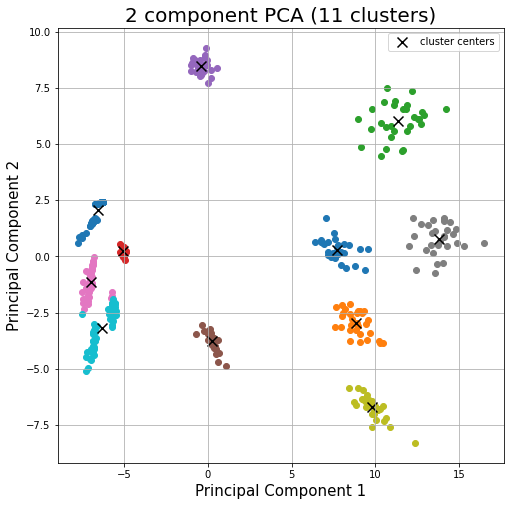

For 12 clusters:
Raw cost: 500110.9129013813
PCA cost: 251.7343514579689
Adjusted Rand Index: 0.6725808350406309


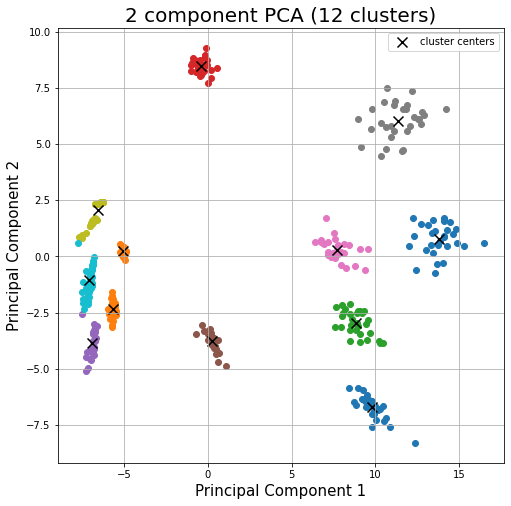

For 13 clusters:
Raw cost: 476667.2156679393
PCA cost: 223.1699433610779
Adjusted Rand Index: 0.7461003984119615


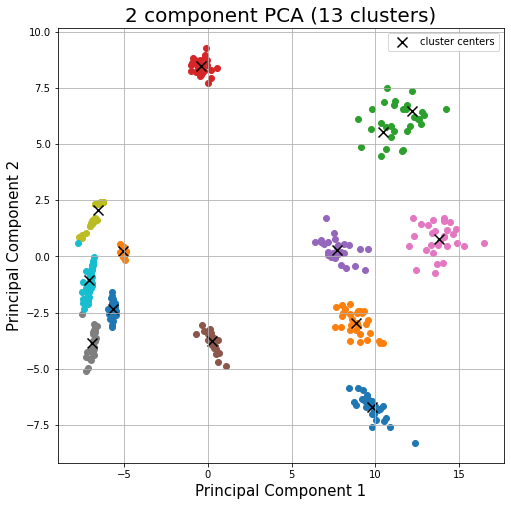

For 14 clusters:
Raw cost: 435517.2898885447
PCA cost: 207.08189876319287
Adjusted Rand Index: 0.6977798574888046


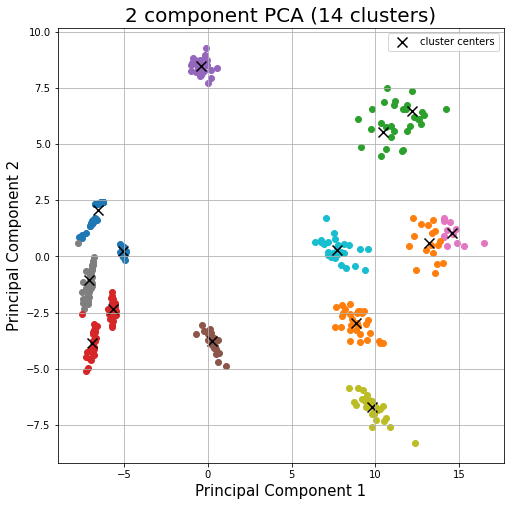

For 15 clusters:
Raw cost: 409481.2556536653
PCA cost: 182.45664395056193
Adjusted Rand Index: 0.7755485953507036


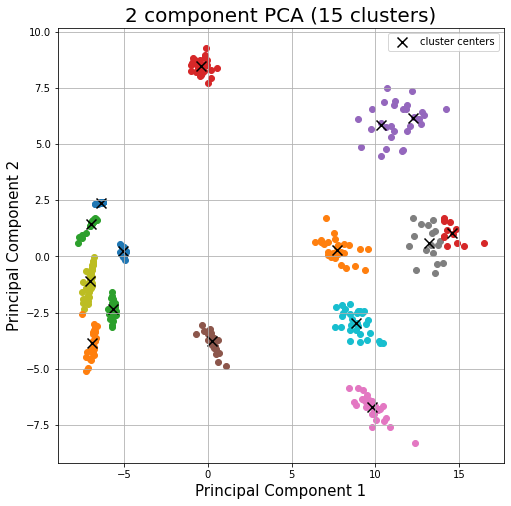

For 16 clusters:
Raw cost: 384747.55922057293
PCA cost: 170.64489926282022
Adjusted Rand Index: 0.8856610951671977


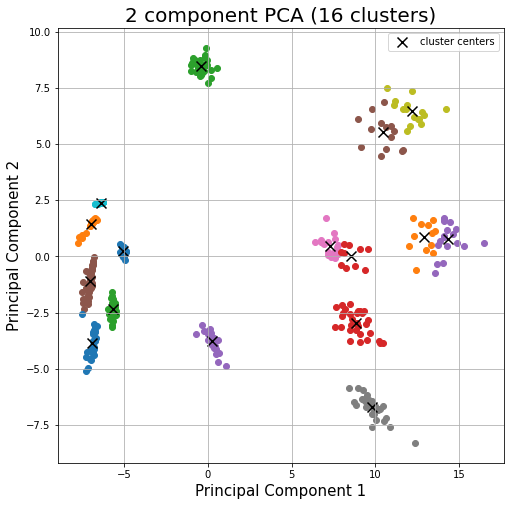

For 17 clusters:
Raw cost: 363177.7773560001
PCA cost: 160.7746150982949
Adjusted Rand Index: 0.8937257506850012


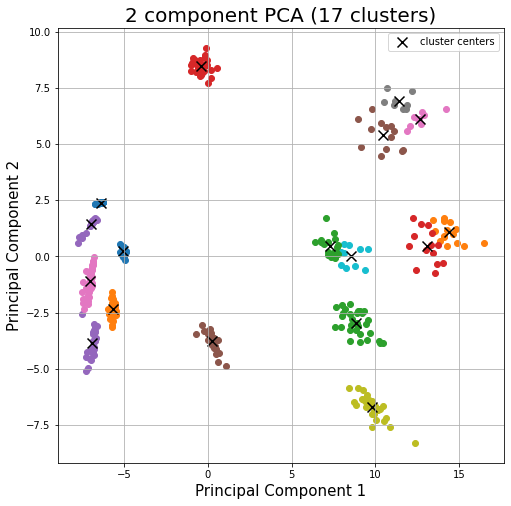

For 18 clusters:
Raw cost: 347352.36407258356
PCA cost: 146.22059444466026
Adjusted Rand Index: 0.8310777587048848


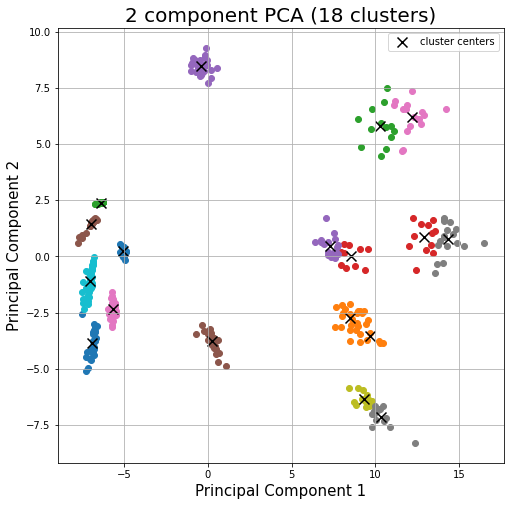

For 19 clusters:
Raw cost: 329254.3828199759
PCA cost: 136.762196072156
Adjusted Rand Index: 0.8041803155651287


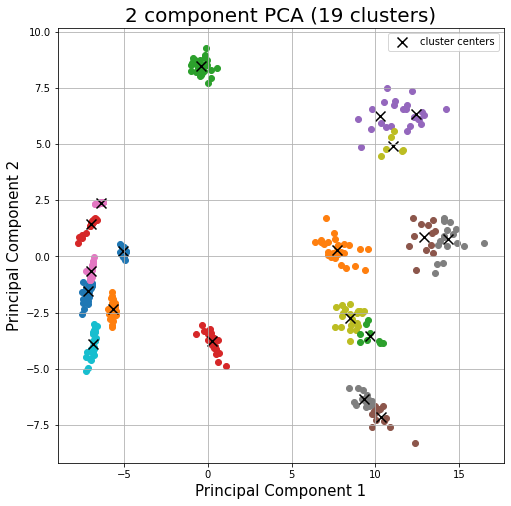

For 20 clusters:
Raw cost: 314346.8861311339
PCA cost: 124.8345645055424
Adjusted Rand Index: 0.7765405479464517


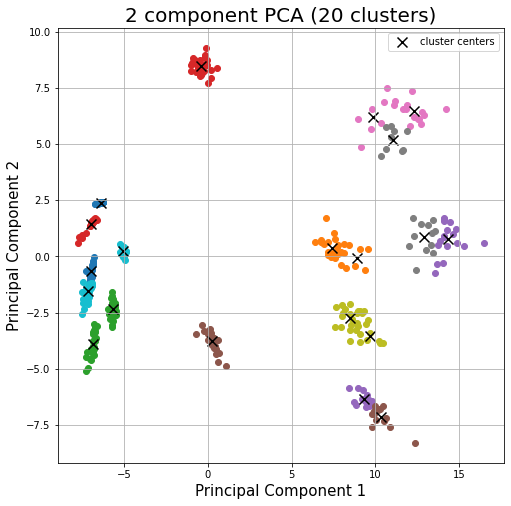

In [56]:
# explore K-means clustering with k = [0,20]
for k in range(1, 21):
  # raw data
  cluster_raw = df.loc[:, features]
  kmeans_raw = KMeans(n_clusters=k).fit(cluster_raw)
  cluster_raw['cluster'] = kmeans_raw.labels_
  cluster_raw.set_index('cluster', inplace=True, append=True)

  # pca-reduced data
  cluster_pca = df_reduced.drop(columns=['hospitalized_new'])
  kmeans_pca = KMeans(n_clusters=k).fit(cluster_pca)
  cluster_pca['cluster'] = kmeans_pca.labels_
  cluster_pca.set_index('cluster', inplace=True, append=True)

  # compare clustering between raw and pca using adjusted rand score
  score = adjusted_rand_score(kmeans_raw.labels_, kmeans_pca.labels_)

  print("For", k, "clusters:")
  print("Raw cost:", kmeans_raw.inertia_)
  print("PCA cost:", kmeans_pca.inertia_)
  print("Adjusted Rand Index:", score)

  # plot clustering of pca reduced data
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA (' + str(k) + ' clusters)', fontsize = 20)
  ax.grid()
  for i in range(k):
      series = cluster_pca.query('cluster==' + str(i))
      ax.scatter(series['principal component 1'], series['principal component 2'])
  ax.scatter(kmeans_pca.cluster_centers_[:, 0],
             kmeans_pca.cluster_centers_[:, 1],
             marker='x', s=100, facecolor='black', label='cluster centers')
  ax.legend()
  plt.show()


## Task 3: Supervised Learning

###3.1 Split the data (region): keep all data from some regions in the validation set and train on the rest (keep 80% regions in training set and 20% in validation set, doing this multiple times to estimate cross-validation results).

In [57]:
df_copy = df
df = df.reset_index()
#print(df)
# calculate mean for each region
df_mean = df.drop(['hospitalized_new', 'hospitalized_cumulative', 'date'], axis=1)
df_mean = df_mean.groupby(['open_covid_region_code']).mean()
df_mean = df_mean.mean(axis=1)
df_mean = pd.DataFrame(df_mean)
df_mean.columns = ['median']
print(df_mean)
print(features)

df['date'] = df['date'] - df['date'][0]
for i in range(len(df)):
  df['date'][i] = df['date'][i].days

# Re-normalization based on regions
df = df.set_index('open_covid_region_code')
df = pd.merge(df_mean, df, left_index=True, right_index=True)
#df = df.div(df[''])
#print(df)

regions = [ ['US-AK', 'US-DC', 'US-DE'], ['US-HI', 'US-ID', 'US-ME'], ['US-MT', 'US-ND', 'US-NH'], ['US-NM', 'US-RI', 'US-SD'], ['US-VT', 'US-WV', 'US-WY'] ]
regions_copy = regions

X = df[features].div(df['median'], axis=0)
Y = df[['hospitalized_new', 'hospitalized_cumulative']]
print(X)


                           median
open_covid_region_code           
US-AK                    8.647672
US-DC                    1.243738
US-DE                    4.076171
US-HI                    1.425758
US-ID                    0.373015
US-ME                    2.234893
US-MT                    8.161353
US-ND                    7.035532
US-NH                    1.857510
US-NM                    0.409504
US-RI                    2.453338
US-SD                    7.547275
US-VT                   10.116364
US-WV                    3.319201
US-WY                    3.289719
['symptom:Adrenal crisis', 'symptom:Ageusia', 'symptom:Allergic conjunctivitis', 'symptom:Amblyopia', 'symptom:Amenorrhea', 'symptom:Angular cheilitis', 'symptom:Anosmia', 'symptom:Aphonia', 'symptom:Ascites', 'symptom:Asphyxia', 'symptom:Atheroma', 'symptom:Auditory hallucination', 'symptom:Balance disorder', "symptom:Beau's lines", 'symptom:Bleeding on probing', 'symptom:Burning Chest Pain', 'symptom:Burning mouth sy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


###3.2 Split the data (time): keep data for the last couple of timepoints (keep data after `2020-08-10') from all regions in the validation set and train on the rest of the data.

In [58]:
# Select date to split data (training data will have dates up to and including split date)
split_date = np.datetime64('2020-08-09')

# Raw Data

# Drop region index
df_dates = df_copy.reset_index(level='open_covid_region_code', drop=True)

# Split dataframe into training and validation sets
# Use .to_numpy() to get sdarray
dates_train = df_dates[df_dates.index <= split_date]
dates_train_x = dates_train.drop(columns=['hospitalized_new', 'hospitalized_cumulative']).to_numpy()
dates_train_y = dates_train[:]['hospitalized_new'].to_numpy()

dates_val = df_dates[df_dates.index > split_date]
dates_val_x = dates_val.drop(columns=['hospitalized_new', 'hospitalized_cumulative']).to_numpy()
dates_val_y = dates_val[:]['hospitalized_new'].to_numpy()

# PCA reduced Data
r_dates_train = df_reduced[df_dates.index <= split_date]
r_dates_train_x = r_dates_train.drop(columns=['hospitalized_new']).to_numpy()
r_dates_train_y = dates_train_y

r_dates_val = df_reduced[df_dates.index > split_date]
r_dates_val_x = r_dates_val.drop(columns=['hospitalized_new']).to_numpy()
r_dates_val_y = dates_val_y

### 3.3 Supervised Learning: KNN (region) (5-fold cross-validation)

In [59]:
rmse_val = []
for K in range(90):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    err = 0
    for i in range(len(regions)):
      regions_copy = regions.copy()
      x_test = X.loc[regions_copy[i]]
      y_test = Y.loc[regions_copy[i]]
      regions_copy.remove(regions_copy[i])
      x_train = X.loc[[item for sublist in regions_copy for item in sublist]]
      y_train = Y.loc[[item for sublist in regions_copy for item in sublist]]
      model.fit(x_train, y_train)
      pred = model.predict(x_test)
      err = err + math.sqrt(mean_squared_error(y_test,pred))
    error = err / len(regions)
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 4477.517512141046
RMSE value for k=  2 is: 4270.652230148366
RMSE value for k=  3 is: 4223.040141181142
RMSE value for k=  4 is: 4174.582357725587
RMSE value for k=  5 is: 4247.010232816456
RMSE value for k=  6 is: 4285.099964258049
RMSE value for k=  7 is: 4329.806656238112
RMSE value for k=  8 is: 4376.26256176744
RMSE value for k=  9 is: 4404.545142838562
RMSE value for k=  10 is: 4402.909729626857
RMSE value for k=  11 is: 4390.393264408287
RMSE value for k=  12 is: 4416.357994573613
RMSE value for k=  13 is: 4420.721231288206
RMSE value for k=  14 is: 4426.971577310997
RMSE value for k=  15 is: 4438.982018238604
RMSE value for k=  16 is: 4429.865905909905
RMSE value for k=  17 is: 4412.864224323041
RMSE value for k=  18 is: 4399.182527649324
RMSE value for k=  19 is: 4403.796988743658
RMSE value for k=  20 is: 4381.360298635414
RMSE value for k=  21 is: 4368.1456574286
RMSE value for k=  22 is: 4354.312858755346
RMSE value for k=  23 is: 4311.583859506119


###3.4 Supervised Learning: KNN (time)

In [60]:
rmse_val = []
r_rmse_val = []

for k in range(1, 101):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    # raw
    model.fit(dates_train_x, dates_train_y)
    pred = model.predict(dates_val_x)
    error = math.sqrt(mean_squared_error(dates_val_y, pred))
    rmse_val.append(error)

    # reduced
    model.fit(r_dates_train_x, r_dates_train_y)
    pred = model.predict(r_dates_val_x)
    r_error = math.sqrt(mean_squared_error(r_dates_val_y, pred))
    r_rmse_val.append(r_error)

    print("RMSE value for k =", k, "is: %.5f raw, %.5f reduced" % (error, r_error))

RMSE value for k = 1 is: 43.18531 raw, 51.56586 reduced
RMSE value for k = 2 is: 41.63675 raw, 46.30610 reduced
RMSE value for k = 3 is: 40.05125 raw, 44.07436 reduced
RMSE value for k = 4 is: 40.44323 raw, 46.03065 reduced
RMSE value for k = 5 is: 40.61964 raw, 42.55922 reduced
RMSE value for k = 6 is: 40.39861 raw, 40.34668 reduced
RMSE value for k = 7 is: 39.69433 raw, 38.56955 reduced
RMSE value for k = 8 is: 39.84403 raw, 39.95820 reduced
RMSE value for k = 9 is: 38.09379 raw, 41.15580 reduced
RMSE value for k = 10 is: 38.31928 raw, 41.13808 reduced
RMSE value for k = 11 is: 37.69593 raw, 40.64050 reduced
RMSE value for k = 12 is: 37.08715 raw, 40.08982 reduced
RMSE value for k = 13 is: 36.74232 raw, 38.61282 reduced
RMSE value for k = 14 is: 36.59832 raw, 37.86020 reduced
RMSE value for k = 15 is: 36.85542 raw, 38.15093 reduced
RMSE value for k = 16 is: 36.78568 raw, 37.81018 reduced
RMSE value for k = 17 is: 38.20876 raw, 36.76635 reduced
RMSE value for k = 18 is: 37.46709 raw, 

###3.5 Supervised Learning: Decision Tree (region) (5-fold cross-validation)

In [61]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model_2 = tree.DecisionTreeClassifier()
# # K-fold Cross-Validation， k = 5
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, random_state=None, shuffle=False)

# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(model, x_train, y_train['hospitalized_new'], scoring='accuracy', cv=kf)
# # report performance
# from numpy import mean
# from numpy import std
# print("hospitalized_new: " + str(mean(scores)))
# # model.score(x_test,y_test['hospitalized_new'])

# scores = cross_val_score(model, x_train, y_train['hospitalized_cumulative'], scoring='accuracy', cv=kf)
# print("hospitalized_cumulative: "+ str(mean(scores)))

s_new = 0
s_cum = 0
for i in range(len(regions)):
      regions_copy = regions.copy()
      x_test = X.loc[regions_copy[i]]
      y_test = Y.loc[regions_copy[i]]
      regions_copy.remove(regions_copy[i])
      x_train = X.loc[[item for sublist in regions_copy for item in sublist]]
      y_train = Y.loc[[item for sublist in regions_copy for item in sublist]]
      model.fit(x_train, y_train['hospitalized_new'])
      model_2.fit(x_train, y_train['hospitalized_cumulative'])
      #s = model.score(x_test,y_test)
      #pred = model.predict(x_test)
      s_new = s_new + model.score(x_test,y_test['hospitalized_new'])
      s_cum = s_cum + model_2.score(x_test,y_test['hospitalized_cumulative'])
score_new = s_new / len(regions)
score_cum = s_cum / len(regions)
print(score_new)
print(score_cum)

0.2488460852505796
0.20440109204154147


###3.6 Supervised Learning: Decision Tree (time)

In [62]:
model.fit(dates_train_x,dates_train_y)
model.score(dates_val_x,dates_val_y)

0.3523809523809524

### 3.7 **(Optional)** Explore other prediction strategies. For example, one strategy could be to learn separate models for predicting hospitalization in each region or cluster from Task 2.